# Women in Data Science 2022

# Section 1: Notebook set up

## Imports

In [1]:
import random, os

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import xgboost as xgb
import lightgbm as lgb
import catboost as cb

from copy import deepcopy

from sklearn.cluster import KMeans
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import VotingRegressor
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import BayesianRidge, Ridge
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import SimpleImputer, IterativeImputer
from sklearn.compose import make_column_transformer, TransformedTargetRegressor
from sklearn.model_selection import (
    RandomizedSearchCV,
    train_test_split,
    cross_validate,
    cross_val_score,
    LeaveOneGroupOut,
)
from sklearn.preprocessing import (
    OneHotEncoder,
    OrdinalEncoder,
    PowerTransformer,
    StandardScaler,
)

from sklearn.utils.validation import check_is_fitted

from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer

## Global notebook setup

### Global variables

In [2]:
TRAIN_PATH = "../input/widsdatathon2022/train.csv"
TEST_PATH = "../input/widsdatathon2022/test.csv"
SUBMISSION_PATH = "../output/"
TARGET = "site_eui"
SCORE = "neg_root_mean_squared_error"
SEED = 777

### Display options

In [3]:
pd.options.display.max_rows = 100

# Section 2: Data preprocessing

## Read in data

In [4]:
def read_data(train_path, test_path):
    """Reads in train and test data."""
    train_df = pd.read_csv(train_path)
    test_df = pd.read_csv(test_path)
    return train_df, test_df

In [5]:
train, test = read_data(TRAIN_PATH, TEST_PATH)

In [6]:
train.shape

(75757, 64)

In [7]:
test.shape

(9705, 63)

## Duplicated data

In [8]:
def get_duplicates(df, drop_cols=None):
    """Returns duplicated values in a dataframe."""
    if drop_cols is not None:
        return df[df.drop(columns=drop_cols).duplicated()]
    else:
        return df[df.duplicated()]

In [9]:
def remove_duplicates(df, drop_cols=None):
    """Removes duplicated values in a dataframe"""
    df_clean = df.copy()
    if drop_cols is not None:
        df_clean = df_clean[~df_clean.drop(columns=drop_cols).duplicated()]
    else:
        df_clean = df_clean[~df_clean.duplicated()]
    return df_clean.reset_index(drop=True)

In [10]:
train_duplicates = get_duplicates(train, ["id"])
test_duplicates = get_duplicates(test, ["id"])

In [11]:
train_duplicates.shape

(39, 64)

In [12]:
test_duplicates.shape

(5, 63)

In [13]:
train = remove_duplicates(train, ["id"])

In [14]:
train.shape

(75718, 64)

## Separate data by facility (residential vs. commercial)

In [15]:
def split_building_data(df, groups):
    """Creates separate dataframes based on facility type groups"""
    dfs = {}

    for name, group in groups.items():
        group_df = df.query("facility_type in @group")
        dfs[name] = group_df.reset_index(drop=True)

    return dfs

In [16]:
# groups = {
#     "residential": {
#         '2to4_Unit_Building', '5plus_Unit_Building', 'Mixed_Use_Commercial_and_Residential',
#         'Mixed_Use_Predominantly_Residential', 'Multifamily_Uncategorized'
#     },
#     "commercial": {
#         'Mixed_Use_Predominantly_Commercial', 'Commercial_Other', 'Commercial_Unknown',
#         'Data_Center', 'Education_College_or_university', 'Education_Other_classroom',
#         'Education_Preschool_or_daycare', 'Education_Uncategorized', 'Food_Sales',
#         'Food_Service_Other', 'Food_Service_Restaurant_or_cafeteria', 'Food_Service_Uncategorized',
#         'Grocery_store_or_food_market', 'Health_Care_Inpatient', 'Health_Care_Outpatient_Clinic',
#         'Health_Care_Outpatient_Uncategorized', 'Health_Care_Uncategorized', 'Industrial',
#         'Laboratory', 'Lodging_Dormitory_or_fraternity_sorority', 'Lodging_Hotel', 'Lodging_Other',
#         'Lodging_Uncategorized', 'Nursing_Home', 'Office_Bank_or_other_financial', 'Office_Medical_non_diagnostic',
#         'Office_Mixed_use', 'Office_Uncategorized', 'Parking_Garage', 'Public_Assembly_Drama_theater',
#         'Public_Assembly_Entertainment_culture', 'Public_Assembly_Library', 'Public_Assembly_Movie_Theater',
#         'Public_Assembly_Other', 'Public_Assembly_Recreation', 'Public_Assembly_Social_meeting',
#         'Public_Assembly_Stadium', 'Public_Assembly_Uncategorized', 'Public_Safety_Courthouse',
#         'Public_Safety_Fire_or_police_station', 'Public_Safety_Penitentiary', 'Public_Safety_Uncategorized',
#         'Religious_worship', 'Retail_Enclosed_mall', 'Retail_Strip_shopping_mall', 'Retail_Uncategorized',
#         'Retail_Vehicle_dealership_showroom', 'Service_Drycleaning_or_Laundry', 'Service_Uncategorized',
#         'Service_Vehicle_service_repair_shop', 'Warehouse_Distribution_or_Shipping_center', 'Warehouse_Nonrefrigerated',
#         'Warehouse_Refrigerated', 'Warehouse_Selfstorage', 'Warehouse_Uncategorized'
#     }
# }

groups = {
    "multifamily": {
        "Multifamily_Uncategorized"
    },
    "residential": {
        '2to4_Unit_Building', '5plus_Unit_Building', 'Mixed_Use_Commercial_and_Residential',
        'Mixed_Use_Predominantly_Residential'
    },
    "commercial": {
        'Mixed_Use_Predominantly_Commercial', 'Commercial_Other', 'Commercial_Unknown',
        'Data_Center', 'Education_College_or_university', 'Education_Other_classroom',
        'Education_Preschool_or_daycare', 'Education_Uncategorized', 'Food_Sales',
        'Food_Service_Other', 'Food_Service_Restaurant_or_cafeteria', 'Food_Service_Uncategorized',
        'Grocery_store_or_food_market', 'Health_Care_Inpatient', 'Health_Care_Outpatient_Clinic',
        'Health_Care_Outpatient_Uncategorized', 'Health_Care_Uncategorized', 'Industrial',
        'Laboratory', 'Lodging_Dormitory_or_fraternity_sorority', 'Lodging_Hotel', 'Lodging_Other',
        'Lodging_Uncategorized', 'Nursing_Home', 'Parking_Garage', 'Public_Assembly_Drama_theater',
        'Public_Assembly_Entertainment_culture', 'Public_Assembly_Library', 'Public_Assembly_Movie_Theater',
        'Public_Assembly_Other', 'Public_Assembly_Recreation', 'Public_Assembly_Social_meeting',
        'Public_Assembly_Stadium', 'Public_Assembly_Uncategorized', 'Public_Safety_Courthouse',
        'Public_Safety_Fire_or_police_station', 'Public_Safety_Penitentiary', 'Public_Safety_Uncategorized',
        'Religious_worship', 'Retail_Enclosed_mall', 'Retail_Strip_shopping_mall', 'Retail_Uncategorized',
        'Retail_Vehicle_dealership_showroom', 'Service_Drycleaning_or_Laundry', 'Service_Uncategorized',
        'Service_Vehicle_service_repair_shop', 'Warehouse_Distribution_or_Shipping_center', 
    },
    "office":{
        'Office_Bank_or_other_financial', 'Office_Medical_non_diagnostic', 'Office_Mixed_use', 'Office_Uncategorized',
    },
    "warehouse":{
        'Warehouse_Nonrefrigerated', 'Warehouse_Refrigerated', 'Warehouse_Selfstorage', 'Warehouse_Uncategorized'
    }
}

In [17]:
train_dfs = split_building_data(train, groups)
test_dfs = split_building_data(test, groups)

## Missing data

In [18]:
def count_missing(df):
    """Counts the missing values in a dataframe"""
    missing_df = pd.DataFrame(
        df.isna().sum().sort_values(ascending=False), columns=["count"]
    )
    missing_df["percent"] = missing_df["count"] / df.shape[0]
    return missing_df.query("count != 0")

In [19]:
# count_missing(train_dfs["residential"])
# count_missing(test_dfs["residential"])
# count_missing(train_dfs["commercial"])
# count_missing(test_dfs["commercial"])

## Data imputation: `energy_star`, `year_built`

In [20]:
def iterative_impute(train_df, test_df, model, ct, target, feat_names, seed):
    """Iteratively impute missing values with a desired model"""
    train_imp = ct.fit_transform(train_df.drop(columns=[target]))
    test_imp = ct.transform(test_df)

    imputer = IterativeImputer(estimator=model, random_state=seed)

    # TODO: fix feat_names with appropriate sklearn method
    cols = (
        ct.named_transformers_["onehotencoder"].get_feature_names().tolist()
        + feat_names
    )

    train_imp = pd.DataFrame(imputer.fit_transform(train_imp), columns=cols)
    test_imp = pd.DataFrame(imputer.transform(test_imp), columns=cols)

    return train_imp, test_imp

In [21]:
def replace_columns(df, df_imp, columns):
    """Replace columns in one dataframe with columns from another"""
    df_replaced = df.copy()

    for col in columns:
        df_replaced[col] = df_imp[col]

    return df_replaced

In [22]:
def impute_and_replace(
    train_dfs, test_dfs, model, ct, target, feat_names, replace, seed
):
    """Iterative impute and replace values for multiple dataframes"""
    train_dfs_imp = {}
    test_dfs_imp = {}

    # iterative imputation
    for (name1, train_df), (name2, test_df) in zip(train_dfs.items(), test_dfs.items()):
        assert name1 == name2
        train_imp, test_imp = iterative_impute(
            train_df, test_df, model, ct, target, feat_names, seed
        )
        train_dfs_imp[name1] = train_imp
        test_dfs_imp[name1] = test_imp

    # replace train columns with missing values
    for (name1, df), (name2, imp_df) in zip(train_dfs.items(), train_dfs_imp.items()):
        assert name1 == name2
        train_dfs[name1] = replace_columns(df, imp_df, replace)

    # replace test columns with missing values
    for (name1, df), (name2, imp_df) in zip(test_dfs.items(), test_dfs_imp.items()):
        assert name1 == name2
        test_dfs[name1] = replace_columns(df, imp_df, replace)

    return train_dfs, test_dfs

In [23]:
cat_imp = [
    'Year_Factor', 'State_Factor', 'building_class', 'facility_type'
]

num_imp = [
    'floor_area', 'year_built', 'energy_star_rating', 'ELEVATION',
    'cooling_degree_days', 'heating_degree_days', 'precipitation_inches',
    'snowfall_inches', 'snowdepth_inches', 'avg_temp'
]

drop_imp = [
    'january_min_temp', 'january_avg_temp', 'january_max_temp',
    'february_min_temp', 'february_avg_temp', 'february_max_temp',
    'march_min_temp', 'march_avg_temp', 'march_max_temp', 'april_min_temp',
    'april_avg_temp', 'april_max_temp', 'may_min_temp', 'may_avg_temp',
    'may_max_temp', 'june_min_temp', 'june_avg_temp', 'june_max_temp',
    'july_min_temp', 'july_avg_temp', 'july_max_temp', 'august_min_temp',
    'august_avg_temp', 'august_max_temp', 'september_min_temp',
    'september_avg_temp', 'september_max_temp', 'october_min_temp',
    'october_avg_temp', 'october_max_temp', 'november_min_temp',
    'november_avg_temp', 'november_max_temp', 'december_min_temp',
    'december_avg_temp', 'december_max_temp', 'days_below_30F', 'days_below_20F',
    'days_below_10F', 'days_below_0F', 'days_above_80F', 'days_above_90F',
    'days_above_100F', 'days_above_110F', 'direction_max_wind_speed',
    'direction_peak_wind_speed', 'max_wind_speed', 'days_with_fog',
    'id'
]

In [24]:
ct_imp = make_column_transformer(
    (OneHotEncoder(handle_unknown="ignore", sparse=False), cat_imp),
    ("passthrough", num_imp),
    ("drop", drop_imp)
)

# change to better model later
model = Ridge()
replace = ["energy_star_rating", "year_built"]

In [25]:
train_dfs, test_dfs = impute_and_replace(
    train_dfs, test_dfs, model, ct_imp, TARGET, num_imp, replace, SEED
)

In [26]:
# count_missing(train_dfs["residential"])
# count_missing(test_dfs["residential"])
# count_missing(train_dfs["commercial"])
# count_missing(test_dfs["commercial"])

# Feature Engineering

## New Features: Entire Dataset

In [27]:
def has_feature(df, feat):
    """Adds a boolean feature if a feature exists or now"""
    return df[feat].notna().astype(int)

In [28]:
def feature_engineer(train_df, test_df):
    """Feature engineer the wids 2022 dataset"""
    train_df_eng = train_df.copy()
    test_df_eng = test_df.copy()
    
    # whether or not a building has a fog detector
    train_df_eng["has_fog_detector"] = has_feature(train_df_eng, "days_with_fog")
    test_df_eng["has_fog_detector"] = has_feature(test_df_eng, "days_with_fog")
    
    # whether or not a building has a wind detector
    train_df_eng["has_wind_detector"] = has_feature(train_df_eng, "max_wind_speed")
    test_df_eng["has_wind_detector"] = has_feature(test_df_eng, "max_wind_speed")
    
    return train_df_eng, test_df_eng

In [29]:
def feature_engineer_multiple(train_dfs, test_dfs):
    """Feature engineer multiple dataframes at once"""
    train_dfs_eng = {}
    test_dfs_eng = {}

    for (name1, train_df), (name2, test_df) in zip(train_dfs.items(), test_dfs.items()):
        assert name1 == name2
        train_dfs_eng[name1], test_dfs_eng[name2] = feature_engineer(train_df, test_df)

    return train_dfs_eng, test_dfs_eng

In [30]:
train_dfs_eng, test_dfs_eng = feature_engineer_multiple(train_dfs, test_dfs)

## Cluster buildings

In [31]:
# def plot_elbow_curve(X, model, k):
#     visualizer = KElbowVisualizer(model, k=k)
#     visualizer.fit(X)
#     visualizer.show()
#     return visualizer

In [32]:
# def plot_silhouette(X, model):
#     visualizer = SilhouetteVisualizer(model, colors="yellowbrick")
#     visualizer.fit(X)
#     visualizer.show()
#     return visualizer

In [33]:
# def add_cluster_labels(model, ct, train_df, test_df, target):
#     """Adds cluster labels as a feature"""
#     train_df_cluster = train_df.copy()
#     test_df_cluster = test_df.copy()

#     X_cluster = ct.fit_transform(train_df.drop(columns=[target]))
#     test_cluster = ct.transform(test_df)

#     model.fit(X_cluster)

#     train_df_cluster["cluster_label"] = model.labels_
#     test_df_cluster["cluster_label"] = model.predict(test_cluster)

#     return train_df_cluster, test_df_cluster

In [34]:
# cat_cluster = [
#     'building_class', 'facility_type'
# ]

# num_cluster = [
#     'floor_area', 'year_built', 'energy_star_rating', 'ELEVATION',
#     'cooling_degree_days', 'heating_degree_days', 'precipitation_inches',
#     'snowfall_inches', 'snowdepth_inches', 'avg_temp'
# ]

# passthrough_cluster = [
#     'has_fog_detector', 'has_wind_detector'
# ]

# drop_cluster = [
#     'Year_Factor', 'State_Factor', 'january_min_temp', 'january_avg_temp', 'january_max_temp',
#     'february_min_temp', 'february_avg_temp', 'february_max_temp',
#     'march_min_temp', 'march_avg_temp', 'march_max_temp', 'april_min_temp',
#     'april_avg_temp', 'april_max_temp', 'may_min_temp', 'may_avg_temp',
#     'may_max_temp', 'june_min_temp', 'june_avg_temp', 'june_max_temp',
#     'july_min_temp', 'july_avg_temp', 'july_max_temp', 'august_min_temp',
#     'august_avg_temp', 'august_max_temp', 'september_min_temp',
#     'september_avg_temp', 'september_max_temp', 'october_min_temp',
#     'october_avg_temp', 'october_max_temp', 'november_min_temp',
#     'november_avg_temp', 'november_max_temp', 'december_min_temp',
#     'december_avg_temp', 'december_max_temp', 'days_below_30F', 'days_below_20F',
#     'days_below_10F', 'days_below_0F', 'days_above_80F', 'days_above_90F',
#     'days_above_100F', 'days_above_110F', 'direction_max_wind_speed',
#     'direction_peak_wind_speed', 'max_wind_speed', 'days_with_fog',
#     'id'
# ]

In [35]:
# ct_cluster = make_column_transformer(
#     (OneHotEncoder(handle_unknown="ignore"), cat_cluster),
#     (StandardScaler(), num_cluster),
#     ("passthrough", passthrough_cluster),
#     ("drop", drop_cluster)
# )

In [36]:
# X_cluster = ct_cluster.fit_transform(train_df_eng.drop(columns=[TARGET]))

In [37]:
# k = (5, 20)
# model = KMeans()
# visualizer_elbow = plot_elbow_curve(X_cluster, model, k)

In [38]:
# kmeans = KMeans(n_clusters=11, random_state=42)

In [39]:
# plot_silhouette(X_cluster, kmeans)

In [40]:
# train_df_eng, test_df_eng = add_cluster_labels(
#     kmeans,
#     ct_cluster,
#     train_df_eng,
#     test_df_eng,
#     TARGET
# )

# Modelling

## Create `X` and `y` datasets

In [41]:
train_dfs_eng.keys()

dict_keys(['multifamily', 'residential', 'commercial', 'office', 'warehouse'])

In [42]:
test_dfs_eng.keys()

dict_keys(['multifamily', 'residential', 'commercial', 'office', 'warehouse'])

In [43]:
def create_X_y(dfs, target, group_col=None):
    """Separates train dfs into X and y datasets (and optionally, groups)"""
    X_dfs = {}
    y_dfs = {}
    groups = {}

    for name, df in dfs.items():
        X_dfs[name] = df.drop(columns=target)
        y_dfs[name] = df[target]
        
        if group_col is not None:
            groups[name] = df[group_col]
    
    if group_col is not None:
        return X_dfs, y_dfs, groups
    else:
        return X_dfs, y_dfs

In [44]:
X_trains, y_trains, groups = create_X_y(train_dfs_eng, TARGET, "Year_Factor")
X_tests = test_dfs_eng.copy()

## Column transformer

In [45]:
cat = [
    'State_Factor', 'building_class', 'facility_type'
]

num = [
    'floor_area', 'year_built', 'energy_star_rating', 'ELEVATION',
    'cooling_degree_days', 'heating_degree_days', 'precipitation_inches',
    'snowfall_inches', 'snowdepth_inches', 'avg_temp'
]

passthrough = [
    'has_fog_detector', 'has_wind_detector'
]

drop = [
    'Year_Factor', 'january_min_temp', 'january_avg_temp', 'january_max_temp',
    'february_min_temp', 'february_avg_temp', 'february_max_temp',
    'march_min_temp', 'march_avg_temp', 'march_max_temp', 'april_min_temp',
    'april_avg_temp', 'april_max_temp', 'may_min_temp', 'may_avg_temp',
    'may_max_temp', 'june_min_temp', 'june_avg_temp', 'june_max_temp',
    'july_min_temp', 'july_avg_temp', 'july_max_temp', 'august_min_temp',
    'august_avg_temp', 'august_max_temp', 'september_min_temp',
    'september_avg_temp', 'september_max_temp', 'october_min_temp',
    'october_avg_temp', 'october_max_temp', 'november_min_temp',
    'november_avg_temp', 'november_max_temp', 'december_min_temp',
    'december_avg_temp', 'december_max_temp', 'days_below_30F', 'days_below_20F',
    'days_below_10F', 'days_below_0F', 'days_above_80F', 'days_above_90F',
    'days_above_100F', 'days_above_110F', 'direction_max_wind_speed',
    'direction_peak_wind_speed', 'max_wind_speed', 'days_with_fog',
    'id', #'cluster_label'
]

In [46]:
ct = make_column_transformer(
    (OneHotEncoder(handle_unknown="ignore"), cat),
    ("passthrough", num + passthrough),
    ("drop", drop)
)

## Cross validation

In [47]:
def logo_cv_lgb(model, X, y, groups, ct, early_stopping_rounds, return_models=True):
    """Custom cross validation function meant for use with LightGBM Regressor"""

    models = []
    results = []
    train_scores = []
    val_scores = []
    fold = 0
    logo = LeaveOneGroupOut()

    for t, v in logo.split(X, groups=groups):
        fold += 1

        # to avoid lightgbm not saving new fit model (weird??? might be bug in lgb...)
        # might also be bug in my code?  to look into later
        current_model = deepcopy(model)

        # train and val sets for current fold
        X_train, y_train = X.iloc[t], y.iloc[t]
        X_val, y_val = X.iloc[v], y.iloc[v]

        # year factors for current folds
        X_train_yf = np.sort(X_train["Year_Factor"].unique())
        X_val_yf = X_val["Year_Factor"].unique()

        # transform train and val sets
        X_train_tsf = ct.fit_transform(X_train)
        X_val_tsf = ct.transform(X_val)

        # fit and score model w/ early stopping
        current_model.fit(
            X_train_tsf,
            y_train,
            eval_set=[(X_val_tsf, y_val)],
            eval_metric=["rmse"],
            feature_name=ct.get_feature_names(),
            callbacks=[lgb.early_stopping(early_stopping_rounds, verbose=False)],
        )

        # train/val rmse scores
        train_rmse = mean_squared_error(
            y_true=y_train, y_pred=current_model.predict(X_train_tsf), squared=False
        )
        val_rmse = current_model.best_score_["valid_0"]["rmse"]

        fold_results = {
            "Fold": fold,
            "Train_shape": X_train.shape,
            "Val_shape": X_val.shape,
            "Train_years": X_train_yf,
            "Val_years": X_val_yf,
            "Train_RMSE": train_rmse,
            "Val_RMSE": val_rmse,
            "RMSE_spread": train_rmse - val_rmse,
        }

        results.append(fold_results)
        train_scores.append(train_rmse)
        val_scores.append(val_rmse)
        models.append(current_model)

    # mean validation score
    results.append(
        {
            "Fold": "MEAN",
            "Train_shape": "N/A",
            "Val_shape": "N/A",
            "Train_years": "N/A",
            "Val_years": "N/A",
            "Train_RMSE": np.mean(train_scores),
            "Val_RMSE": np.mean(val_scores),
            "RMSE_spread": np.mean(train_scores) - np.mean(val_scores),
        }
    )

    results = pd.DataFrame(results)

    if return_models:
        return results, models
    else:
        return results

In [48]:
def logo_cv_lgb_all(
    model, X_trains, y_trains, groups, ct, early_stopping_rounds, return_models=True
):
    """Perform logo cv with LGBM for multiple datasets"""
    results = {}
    models = {}

    for (n1, X), (n2, y), (n3, group) in zip(
        X_trains.items(), y_trains.items(), groups.items()
    ):
        assert n1 == n2 == n3
        results[n1], models[n1] = logo_cv_lgb(
            model, X, y, group, ct, early_stopping_rounds, return_models
        )

    return results, models

In [49]:
def process_cv_results(results):
    """Process cv results for multiple datasets"""
    results_df = pd.DataFrame()

    for name, result in results.items():
        result.insert(0, "facility_group", name)
        results_df = pd.concat([results_df, result])

    return results_df

In [50]:
model = lgb.LGBMRegressor(force_row_wise=True)
results, models = logo_cv_lgb_all(model, X_trains, y_trains, groups, ct, 5)

In [51]:
process_cv_results(results)

,facility_group,Fold,Train_shape,Val_shape,Train_years,Val_years,Train_RMSE,Val_RMSE,RMSE_spread
0,multifamily,1,"(39323, 65)","(107, 65)","[2, 3, 4, 5, 6]",[1],31.424101,37.951848,-6.527747
1,multifamily,2,"(33058, 65)","(6372, 65)","[1, 3, 4, 5, 6]",[2],35.805168,35.557750,0.247418
2,multifamily,3,"(32774, 65)","(6656, 65)","[1, 2, 4, 5, 6]",[3],30.474357,45.537829,-15.063472
3,multifamily,4,"(31930, 65)","(7500, 65)","[1, 2, 3, 5, 6]",[4],30.121021,34.351295,-4.230274
4,multifamily,5,"(30871, 65)","(8559, 65)","[1, 2, 3, 4, 6]",[5],31.651982,24.252581,7.399401
5,multifamily,6,"(29194, 65)","(10236, 65)","[1, 2, 3, 4, 5]",[6],33.959790,24.194163,9.765628
6,multifamily,MEAN,N/A,N/A,N/A,N/A,32.239403,33.640911,-1.401508
0,residential,1,"(3818, 65)","(29, 65)","[2, 3, 4, 5, 6]",[1],26.565748,43.981786,-17.416038
1,residential,2,"(3809, 65)","(38, 65)","[1, 3, 4, 5, 6]",[2],32.529534,41.182777,-8.653243
2,residential,3,"(3784, 65)","(63, 65)","[1, 2, 4, 5, 6]",[3],28.423955,53.908239,-25.484285


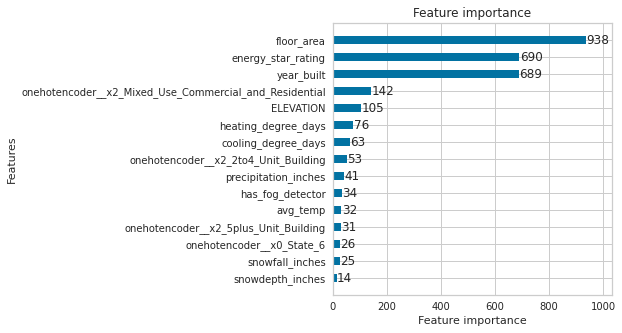

In [52]:
lgb.plot_importance(models["residential"][4], figsize=(5, 5), height=0.5, max_num_features=15);

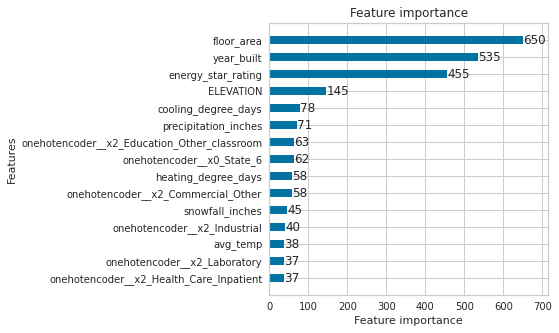

In [53]:
lgb.plot_importance(models["commercial"][4], figsize=(5, 5), height=0.5, max_num_features=15);

## Hyperparameter Tuning

In [54]:
# TODO

## Ensembling

In [55]:
# TODO

# Final models and predictions

In [56]:
# not in utils yet, need to finalize
def train_and_predict(model, X_trains, y_trains, X_tests, ct, target):
    predictions = pd.DataFrame()
    
    for (n1, X_train), (n2, y_train), (n3, X_test) in zip(X_trains.items(), y_trains.items(), X_tests.items()):
        assert n1 == n2 == n3
        
        current_model = deepcopy(model)
        pipe = make_pipeline(
            ct,
            current_model
        )
        
        pipe.fit(X_train, y_train)
        
        pred = {
            "id": X_test["id"],
            target: pipe.predict(X_test)
        }
        
        predictions = pd.concat([predictions, pd.DataFrame(pred)])
    
    predictions = predictions.sort_values("id")

    return predictions

In [57]:
regressor = lgb.LGBMRegressor(force_row_wise=True)

In [58]:
predictions = train_and_predict(regressor, X_trains, y_trains, X_tests, ct, TARGET)

In [59]:
predictions

,id,site_eui
0,75757,270.207593
1,75758,201.661262
2,75759,315.863377
3,75760,258.218162
4,75761,245.218549
...,...,...
1844,85457,15.105917
1845,85458,35.347941
1846,85459,20.346811
1847,85460,20.118134


In [60]:
assert sum(predictions.isna().sum()) == 0

In [61]:
predictions.to_csv("submission.csv", index=False)